# Setup

In [1]:
# Imports
import os
import os.path as osp

import joblib
import numpy as np
import gym
import pandas as pd
import matplotlib.pyplot as plt

import pirl
from pirl import config, experiments

from analysis import common

In [50]:
# Config
experiment_dirs = ['../data/experiments/mountain-car-color-metalearn-20180706_130745-d25020c6f85e7b10775b5e3972eacceebfe9b6af/']

# Value difference

In [29]:
algo_pattern = '(.*)'
env_pattern = '(.*)'
dfs = [common.load_value(x, algo_pattern, env_pattern)
       for x in experiment_dirs]
df = pd.concat(dfs, axis=0)
values = common.aggregate_value(df)
ci = common.plot_ci(values)

In [53]:
idx = (df.index.get_level_values('seed') <= 4) & (df.index.get_level_values('m').isin([1,5,100]))
df.loc[idx].xs('mean', level='type').groupby(['env', 'n', 'm', 'eval']).max()

airl random short  airl sa short  airl so short  airlp random short  airlp so separate short  ppo cts short  expert
env                                         n   m   eval                                                                                                                              
pirl/MountainCarContinuous-2-blue-0-0.05-v0 100 1   irl                      -493.75          61.56          34.59               16.07                    20.79          94.30   94.30
                                                    ppo_cts_short              42.23        -417.63          23.00               74.86                    17.32          94.30   94.30
                                                5   irl                      -479.76          37.83          37.39                9.19                    34.40          94.30   94.30
                                                    ppo_cts_short              52.15       -4141.52          76.86               -1.13                    15.66          94.30   94.30
                                                100 irl                      -481.99          28.02          67.96               25.01                    -3.75          94.30   94.30
                                                    ppo_cts_short              60.73       -2438.11          68.63               17.28                    33.95          94.30   94.30
pirl/MountainCarContinuous-2-red-0-0.05-v0  100 1   irl                      -488.65          56.36          16.63              -17.95                   -37.45          93.79   93.79
                                                    ppo_cts_short              26.31        -109.39          80.07                9.31                    11.93          93.79   93.79
                                                5   irl                      -507.17           2.75         -20.80                0.25                    -0.89          93.79   93.79
                                                    ppo_cts_short              -2.93       -1164.79          20.42               22.35                    16.71          93.79   93.79
                                                100 irl                      -486.35          11.12           4.14               59.52                   -14.10          93.79   93.79
                                                    ppo_cts_short              35.91       -3519.91          77.08               39.17                    31.16          93.79   93.79

# Figures

In [48]:
import collections

pretty_envs = {
    'pirl/MountainCarContinuous-2-red-0-0.05-v0': 'Red',
    'pirl/MountainCarContinuous-2-blue-0-0.05-v0': 'Blue',
}

pretty_algos = collections.OrderedDict([
    ('airl random short', 'SR'),
    ('airl so short', 'SP'),
    ('airlp random short', 'MR'),
    ('airlp so separate short', 'MP'),
    ('ppo cts short', 'PPO'),
])

pretty_eval = {
    'irl': 'IRL',
    'ppo_cts_short': 'Reoptimized',
}

eval_algos = {
    'IRL': ['SP', 'MR', 'MP', 'PPO'],
    'Reoptimized': ['SR', 'SP', 'MR', 'MP', 'PPO'],
}

best_of_seeds = 5
ms = [1, 5, 100]

figs_dir = osp.join('../../population-irl-paper', 'figs')

                              SR     SP     MR     MP    PPO
env  m   eval        type                                   
Blue 1   IRL         mean    NaN  34.59  16.07  20.79  94.30
                     se      NaN  10.01   9.89  10.45   3.93
     5   IRL         mean    NaN  37.39   9.19  34.40  94.30
                     se      NaN  10.05  10.21  10.99   3.93
     100 IRL         mean    NaN  67.96  25.01  -3.75  94.30
                     se      NaN   9.63   9.94  42.33   3.93
Red  1   IRL         mean    NaN  16.63 -17.95 -37.45  93.79
                     se      NaN   9.56   9.61  11.80   0.09
     5   IRL         mean    NaN -20.80   0.25  -0.89  93.79
                     se      NaN  10.36  10.58  10.21   0.09
     100 IRL         mean    NaN   4.14  59.52 -14.10  93.79
                     se      NaN  10.03  10.19  10.82   0.09
Blue 1   Reoptimized mean  42.23  23.00  74.86  17.32  94.30
                     se    10.03  17.17  10.07   9.99   3.93
     5   Reoptimized mea

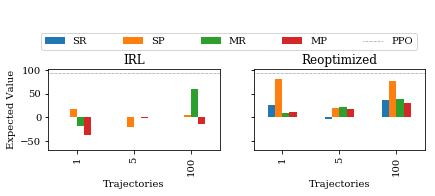

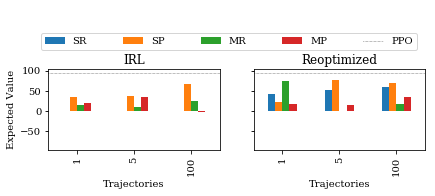

In [52]:
# Filter
idx = ((df.index.get_level_values('seed') < best_of_seeds) & 
       (df.index.get_level_values('m').isin(ms)))
val = df.loc[idx]
# Take maximum across seeds
val = val.stack().unstack('seed').max(axis=1).unstack(-1)
# n should be fixed, get rid of it
val.index = val.index.droplevel('n')
assert val.index.is_unique

val = val.rename(columns=pretty_algos).loc[:, list(pretty_algos.values())]
val = val.rename(index=pretty_envs, level=0).loc[list(pretty_envs.values()), :]
val = val.rename(index=pretty_eval, level='eval')

with plt.style.context([common.style('default'), common.style('twocol')]):
    xs = []
    for eval_type, algos in eval_algos.items():
        xs.append(val.loc[val.index.get_level_values('eval') == eval_type, algos])
    subset = pd.concat(xs, sort=False).loc[:, list(pretty_algos.values())]
    print(subset)
    for env in pretty_envs.values():
        y = subset.xs(env, level='env')
        fig = common.value_multi_bar_chart(y, level='eval', relative='PPO', 
                                           whisker_lw=0)
        out_path = osp.join(figs_dir, 'mountaincar', 'color_{}.pdf'.format(env))
        fig.savefig(out_path, bbox_inches='tight')

# Policy rollout

In [ ]:
def expert_cached_value(rl, env_name, pol_discount=0.99, eval_discount=1.00, seed=1234, episodes=100):
    '''Rollout a cached expert policy for episodes.
       WARNING: This will be slow or just break if policy is not in cache!'''
    gen_policy, _sample, compute_value = config.RL_ALGORITHMS[rl]
    policy, value = experiments._train_policy(rl, pol_discount, env_name, seed, None)
    vmean, vse = value
    print('Cached value: {:.3f} +/- {:.3f}'.format(vmean, 1.96 * vse))
    
    env = gym.make(env_name)
    rmean, rse = compute_value(env, policy, eval_discount, num_episodes=episodes, seed=seed)
    print('Rollout value: {:.3f} +/- {:.3f}'.format(rmean, 1.96 * rse))
    return (vmean, vse), (rmean, rse)

def _policy_value(results_dir, rl, env_name, pol_discount, eval_discount, episodes, seed):
    _gen_policy, _sample, compute_value = config.RL_ALGORITHMS[rl]
    fname = osp.join(results_dir, 'policy.pkl')
    print('Loading policy from ', fname)
    policy = joblib.load(fname)
    env = gym.make(env_name)
    
    mean, se = compute_value(env, policy, eval_discount, num_episodes=episodes, seed=seed)
    print('Rollout value: {:.3f} +/- {:.3f}'.format(mean, 1.96 * se))
    return mean, se

def expert_value(experiment_dir, rl, env_name, pol_discount=0.99, eval_discount=1.00, episodes=100, seed=1234):
    results_dir = osp.join(experiment_dir, 'expert', env_name, rl)
    return _policy_value(results_dir, rl, env_name, pol_discount, eval_discount, episodes, seed)

def irl_eval_value(experiment_dir, irl_name, num_traj, rl, env_name, pol_discount=0.99, eval_discount=1.00, episodes=100, seed=1234):
    results_dir = osp.join(experiment_dir, 'eval', env_name, 
                           '{}:{}:{}'.format(irl_name, num_traj, num_traj), rl)
    return _policy_value(results_dir, rl, env_name, pol_discount, eval_discount, episodes, seed)
    
def irl_value(experiment_dir, irl_name, env_name, num_traj, eval_discount=1.00, episodes=100):
    _irl_algo, _reward_wrapper, compute_value = experiments.make_irl_algo(irl_name)
    irl_dir = osp.join(experiment_dir, 'irl', irl_name)
    if not os.path.exists(irl_dir):
        raise FileNotFoundError("No result directory {}".format(irl_dir))
    
    pop_fname = osp.join(irl_dir, str(num_traj), 'policies.pkl')
    sin_fname = osp.join(irl_dir, env_name, str(num_traj), 'policy.pkl')
    if os.path.exists(pop_fname):
        policies = joblib.load(pop_fname)
        print(policies.keys())
        policy = policies[env_name]
    elif os.path.exists(sin_fname):
        policy = joblib.load(sin_fname)
    else:
        raise FileNotFoundError("Neither {} or {} exists".format(pop_fname, sin_fname))
    
    env = gym.make(env_name)
    mean, se = compute_value(env, policy, discount=eval_discount, num_episodes=episodes)
    print('Rollout value: {} +/- {}'.format(mean, 1.96 * se))

In [ ]:
expert_cached_value('ppo_cts', 'Reacher-v2', episodes=100)

In [ ]:
expert_value(experiment_dir, 'ppo_cts', 'Reacher-v2', episodes=500, seed=1234)

In [ ]:
irl_value(experiment_dir, 'airl', 'Reacher-v2', 1000, episodes=100)

# Visualizing rewards (gridworld only)

In [ ]:
def show_heatmaps(irl_algo, kind='inline', out_dir=None, shape=(9,9), **kwargs):
    data = pd.read_pickle(osp.join(experiment_dir, 'results.pkl'))
    rewards = data['rewards'][irl_algo]
    if kind in ['inline', 'pdf']:
        figs = common.gridworld_heatmap(rewards, shape)
        if out_dir is None:
            for fig in figs:
                display(fig[1])
        else:
            common.save_figs(figs, out_dir)
    elif kind == 'movie':
        common.gridworld_heatmap_movie(out_dir, rewards, shape)
    else:
        assert False

In [ ]:
irl_algos = ['mce', 'mcep_reg1e0']
for irl in irl_algos:
    show_heatmaps(irl, kind='inline', shape=(4,4))
    #show_heatmaps(irl, kind='movie', out_dir='figs/jungle/movies/' + irl)
    #show_heatmaps(irl, kind='movie', out_dir='figs/jungle/' + irl)

# Loss curve (PPO only)

In [ ]:
def ppo_progress(results_dir):
    path = osp.join(results_dir, 'progress.csv')
    df = pd.read_csv(path)
    df = df.set_index('serial_timesteps')
    return df

def expert_ppo_progress(experiment_dir, env_name, rl_name):
    results_dir = osp.join(experiment_dir, 'expert', 
                       experiments.sanitize_env_name(env_name),
                       rl_name)
    return ppo_progress(results_dir)

In [ ]:
envs = ['InvertedPendulum-v2', 'InvertedDoublePendulum-v2', 'Reacher-v2']
for env in envs:
    df = expert_ppo_progress(experiment_dir, env, 'ppo_cts')
    plt.figure()
    df['eprewmean'].plot()
    print(df['eprewmean'].max())
    plt.title(env)

# Evaluate checkpoint

In [ ]:
def load_checkpoint(results_dir, checkpoint_num=None):
    checkpoint_dir = osp.join(results_dir, 'checkpoints')
    if checkpoint_num is None:
        checkpoint_num = max(os.listdir(checkpoint_dir))
    checkpoint_fname = osp.join(checkpoint_dir, checkpoint_num)
    print('Loading from ', checkpoint_fname)
    policy = joblib.load(checkpoint_fname)
    
    return policy

def ppo_value2(results_dir, rl, env_name, pol_discount, eval_discount, episodes):
    _gen_policy, _sample, compute_value = config.RL_ALGORITHMS[rl]
    fname = osp.join(results_dir, 'policy.pkl')
    print('Loading policy from ', fname)
    policy = joblib.load(fname)
    env = gym.make(env_name)
    
    mean, se = compute_value(env, policy, eval_discount, num_episodes=episodes)
    print('Rollout value: {:.3f} +/- {:.3f}'.format(mean, 1.96 * se))
    return mean, se

def ppo_value(policy, env_name, episodes, seed=1234):
    _, _, compute_value = config.RL_ALGORITHMS['ppo_cts']
    env = gym.make(env_name)
    mean, se = compute_value(env, policy, 1.00, num_episodes=episodes, seed=seed)
    print('Rollout value: {:.3f} +/- {:.3f}'.format(mean, 1.96 * se))

In [ ]:
policy = load_checkpoint(osp.join(experiment_dir, 'expert/InvertedPendulum-v2/ppo_cts'), '00488')
ppo_value(policy, 'InvertedPendulum-v2', 500, 1234)